**NOTE** 
- If the kernel doesn't autoselect when you run the code, choose *azureml_py38* from the dropdown menu.
- You might get an error message that no GPU or CUDA-capable device was found. However, the code should still run successfully using CPU resources.

In [24]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
import gzip
import numpy as np

Let's start by getting familiar with the data you'll be using, the Fashion MNIST dataset. This dataset contains 70,000 grayscale images of articles of clothing: 60,000 images for training and 10,000 for testing. The images are square and contain 28 &times; 28 = 784 pixels, where each pixel is represented by a value between 0 and 255. Each of these images is associated with a label, which is an integer between 0 and 9 that classifies the article of clothing. The following dictionary helps us understand the clothing categories corresponding to these integer labels:

In [25]:
labels_map = {
  0: 'T-Shirt',
  1: 'Trouser',
  2: 'Pullover',
  3: 'Dress',
  4: 'Coat',
  5: 'Sandal',
  6: 'Shirt',
  7: 'Sneaker',
  8: 'Bag',
  9: 'Ankle Boot',
}

If you're following this code but executing it outside of this Microsoft Learn sandbox notebook environment, you can load Fashion MNIST by calling the [load_data()](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data) method of the Fashion MNIST dataset in the Keras API, as you can see in the commented out code below. Keras provides an easy way to get not only Fashion MNIST, but many other popular datasets through [tf.keras.datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets). This Learn sandbox notebook already has the data locally, so you can load it directly instead, and create four NumPy arrays containing the training and test data and labels. 

In [26]:
# (training_images, training_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

def read_images(path: str, image_size: int, num_items: int) -> np.ndarray:
  with gzip.open(path, 'rb') as file:
    data = np.frombuffer(file.read(), np.uint8, offset=16)
    data = data.reshape(num_items, image_size, image_size)
  return data

def read_labels(path: str, num_items: int) -> np.ndarray:
  with gzip.open(path, 'rb') as file:
    data = np.frombuffer(file.read(num_items + 8), np.uint8, offset=8)
    data = data.astype(np.int64)
  return data

image_size = 28
num_train = 60000
num_test = 10000

training_images = read_images('data/FashionMNIST/raw/train-images-idx3-ubyte.gz', image_size, num_train)
test_images = read_images('data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz', image_size, num_test)
training_labels = read_labels('data/FashionMNIST/raw/train-labels-idx1-ubyte.gz', num_train)
test_labels = read_labels('data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz', num_test)

Now that you have the data, you can display a sampling of images and corresponding labels from the training data.

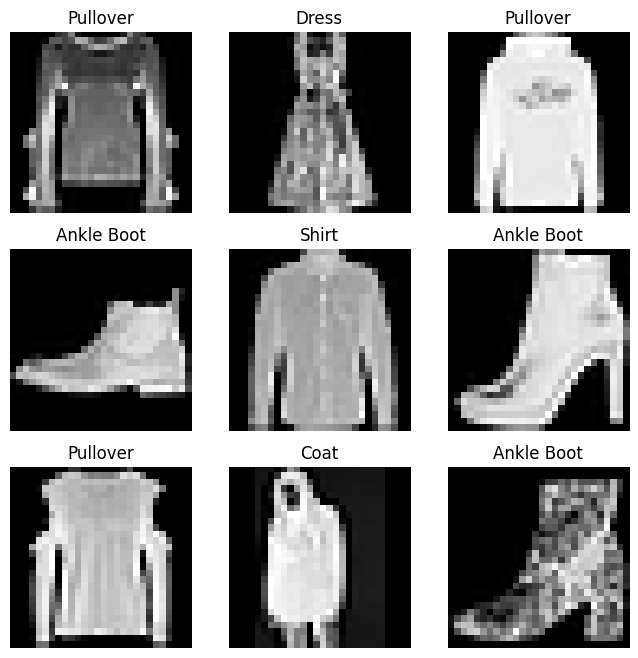

In [27]:
import random
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(8, 8))
cols = 3
rows = 3
for i in range(1, cols * rows + 1):
  sample_idx = random.randint(0, len(training_images))
  image = training_images[sample_idx]
  label = training_labels[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(labels_map[label])
  plt.axis('off')
  plt.imshow(image.squeeze(), cmap='gray')
plt.show()


Let's inspect the first label in the training data:

In [28]:
training_labels[0]

9

As you saw in the `labels_map` dictionary that you printed earlier, this corresponds to an *Ankle boot*. Now let's inspect the image that corresponds to this label:  

In [29]:
training_images[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
          0,   0,  13,  73,   0,   0,   1,   4,   0,   0,   0,   0,   1,
          1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          0,  36, 136, 127,  62,  54,   0,   0,   0,   1,   3,   4,   0,
          0,   3],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,
          0, 102, 204, 176, 134, 144, 123,  23,   0,   0,   0,   0,  12,
         10,   0],
       [  

An image is composed of pixel values, and each pixel in the image is of type unsigned int and contains a value between 0 and 255.

For such a small dataset, you could just use the NumPy arrays given by Keras to train the neural network. However, if you had a large dataset, you would need to wrap it in a [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) instance, which handles large data better by making it easy to keep just a portion of it in memory. You can wrap your data in a `Dataset` in this sample, so you're prepared to work with large data in the future.

In [30]:
train_dataset = tf.data.Dataset.from_tensor_slices((training_images, training_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

You saw earlier that each pixel of the image is represented by an unsigned int. In machine learning, you generally want the pixel values of your training data to be floating-point numbers between 0 and 1, so you convert them in the following way:

In [31]:
train_dataset = train_dataset.map(lambda image, label: (float(image) / 255.0, label))
test_dataset = test_dataset.map(lambda image, label: (float(image) / 255.0, label))

You might have noticed that each value returned by the `Dataset` is a tuple containing an image and a label. You divide each value in the image by 255, and keep the label as is. To see the difference, inspect the values of the same image that you inspected earlier. 

In [32]:
train_dataset.as_numpy_iterator().next()[0]

2025-03-17 10:42:44.915698: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 47040000 exceeds 10% of free system memory.


array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

As expected, the pixel values are now floating-point numbers between 0 and 1. 

Now that you have a `Dataset`, you can no longer index it the same way as a NumPy array. Instead, you get an iterator by calling the `as_numpy_iterator` method, and advance it by calling its `next` method. At this point, you have a tuple containing an image and the corresponding label, so you can get the element at index 0 to inspect the image.

Finally, tell the `Dataset` to give us batches of data of size 64, and shuffle the data:

In [33]:
batch_size = 64
train_dataset = train_dataset.batch(batch_size).shuffle(500)
test_dataset = test_dataset.batch(batch_size).shuffle(500)

By specifying the batch size, you're telling the `Dataset` that when you iterate over it, you want to receive not one, but a batch of 64 items instead. If you print the length of the first item returned by the iterator, you can see that you get 64. 

In [34]:
len(train_dataset.as_numpy_iterator().next()[0])

64

Why do you want to get batches of 64 when iterating over the `Dataset`? We'll come back to that in the section on training. First you need to learn about the neural network architecture that you'll use for this sample.